<a href="https://colab.research.google.com/github/ashleykim00/ESAA/blob/main/11_19_%EC%BA%90%EA%B8%80%ED%95%84%EC%82%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive

drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [2]:
#Importing librairies

import pandas as pd 
import numpy as np

# Scikit-learn library: For SVM
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn import svm

import itertools

# Matplotlib library to plot the charts
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

# Library for the statistic data vizualisation
import seaborn

%matplotlib inline

### Data recuperation

In [3]:
data = pd.read_csv('/content/gdrive/MyDrive/creditcard.csv') # Reading the file .csv
df = pd.DataFrame(data) # Converting data to Panda DataFrame

### Data Visualization

In [4]:
df.describe() # Description of statistic features (Sum, Average, Variance, minimum, 1st quartile, 2nd quartile, 3rd Quartile and Maximum)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,1.768627e-15,9.170318e-16,-1.810658e-15,1.693438e-15,1.479045e-15,3.482336e-15,1.392007e-15,-7.528491e-16,4.328772e-16,9.049732e-16,5.085503e-16,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.952742e-01,9.585956e-01,9.153160e-01,8.762529e-01,8.493371e-01,8.381762e-01,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-5.791881e+00,-1.921433e+01,-4.498945e+00,-1.412985e+01,-2.516280e+01,-9.498746e+00,-7.213527e+00,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-6.485393e-01,-4.255740e-01,-5.828843e-01,-4.680368e-01,-4.837483e-01,-4.988498e-01,-4.562989e-01,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,-1.356806e-02,5.060132e-02,4.807155e-02,6.641332e-02,-6.567575e-02,-3.636312e-03,3.734823e-03,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,6.625050e-01,4.931498e-01,6.488208e-01,5.232963e-01,3.996750e-01,5.008067e-01,4.589494e-01,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,1.201891e+01,7.848392e+00,7.126883e+00,1.052677e+01,8.877742e+00,1.731511e+01,9.253526e+00,5.041069e+00,5.591971e+00,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


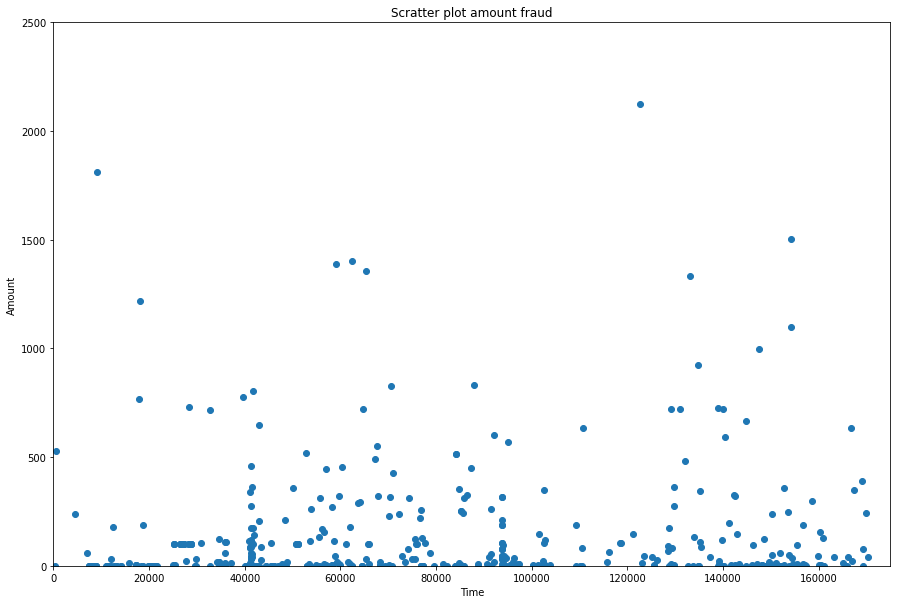

In [5]:
df_fraud = df[df['Class'] == 1] # Recovery of fraud data
plt.figure(figsize=(15,10))
plt.scatter(df_fraud['Time'], df_fraud['Amount']) # Display fraud amounts according to their time
plt.title('Scratter plot amount fraud')
plt.xlabel('Time')
plt.ylabel('Amount')
plt.xlim([0,175000])
plt.ylim([0,2500])
plt.show()

In [6]:
nb_big_fraud = df_fraud[df_fraud['Amount'] > 1000].shape[0] # Recovery of frauds over 1000
print('There are only '+ str(nb_big_fraud) + ' frauds where the amount was bigger than 1000 over ' + str(df_fraud.shape[0]) + ' frauds')

There are only 9 frauds where the amount was bigger than 1000 over 492 frauds


##### Unbalanced data

In [7]:
number_fraud = len(data[data.Class == 1])
number_no_fraud = len(data[data.Class == 0])
print('There are only '+ str(number_fraud) + ' frauds in the original dataset, even though there are ' + str(number_no_fraud) +' no frauds in the dataset.')

There are only 492 frauds in the original dataset, even though there are 284315 no frauds in the dataset.


In [8]:
print("The accuracy of the classifier then would be : "+ str((284315-492)/284315)+ " which is the number of good classification over the number of tuple to classify")

The accuracy of the classifier then would be : 0.998269524998681 which is the number of good classification over the number of tuple to classify


### Correlation of features

In [9]:
df_corr = df.corr() # Calculation of the correlation coefficients in pairs, with the default method:
                    # Pearson, Standard Correlation Coefficient

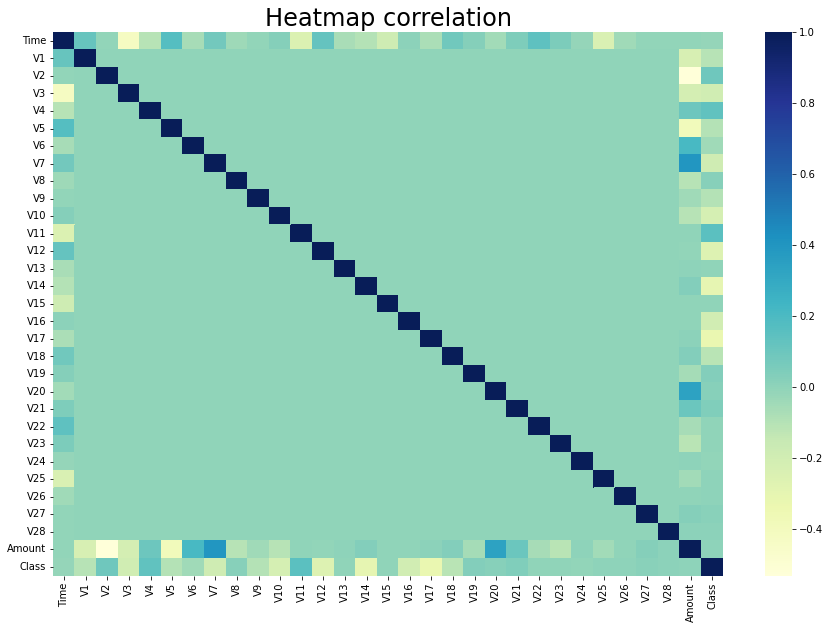

In [10]:
plt.figure(figsize=(15,10))
seaborn.heatmap(df_corr, cmap="YlGnBu") # Displaying the Heatmap
seaborn.set(font_scale=2,style='white')

plt.title('Heatmap correlation')
plt.show()

In [11]:
rank = df_corr['Class'] # Retrieving the correlation coefficients per feature in relation to the feature class
df_rank = pd.DataFrame(rank) 
df_rank = np.abs(df_rank).sort_values(by='Class',ascending=False) # Ranking the absolute values of the coefficients
                                                                  # in descending order
df_rank.dropna(inplace=True) # Removing Missing Data (not a number)

### Data Selection

In [12]:
# We seperate ours data in two groups : a train dataset and a test dataset

# First we build our train dataset
df_train_all = df[0:150000] # We cut in two the original dataset
df_train_1 = df_train_all[df_train_all['Class'] == 1] # We seperate the data which are the frauds and the no frauds
df_train_0 = df_train_all[df_train_all['Class'] == 0]
print('In this dataset, we have ' + str(len(df_train_1)) +" frauds so we need to take a similar number of non-fraud")

df_sample=df_train_0.sample(300)
df_train = df_train_1.append(df_sample) # We gather the frauds with the no frauds. 
df_train = df_train.sample(frac=1) # Then we mix our dataset

In this dataset, we have 293 frauds so we need to take a similar number of non-fraud


In [13]:
X_train = df_train.drop(['Time', 'Class'],axis=1) # We drop the features Time (useless), and the Class (label)
y_train = df_train['Class'] # We create our label
X_train = np.asarray(X_train)
y_train = np.asarray(y_train)

In [14]:
############################## with all the test dataset to see if the model learn correctly ##################
df_test_all = df[150000:]

X_test_all = df_test_all.drop(['Time', 'Class'],axis=1)
y_test_all = df_test_all['Class']
X_test_all = np.asarray(X_test_all)
y_test_all = np.asarray(y_test_all)

In [15]:
X_train_rank = df_train[df_rank.index[1:11]] # We take the first ten ranked features
X_train_rank = np.asarray(X_train_rank)

In [16]:
############################## with all the test dataset to see if the model learn correctly ##################
X_test_all_rank = df_test_all[df_rank.index[1:11]]
X_test_all_rank = np.asarray(X_test_all_rank)
y_test_all = np.asarray(y_test_all)

### Confusion Matrix

In [17]:
class_names=np.array(['0','1']) # Binary label, Class = 1 (fraud) and Class = 0 (no fraud)

In [18]:
# Function to plot the confusion Matrix
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd' 
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Model Selection

#####  use SVM model classifier

In [19]:
classifier = svm.SVC(kernel='linear') # We set a SVM classifier, the default SVM Classifier (Kernel = Radial Basis Function)

In [20]:
classifier.fit(X_train, y_train) # Then we train our model, with our balanced data train.

SVC(kernel='linear')

### Testing the model

In [21]:
prediction_SVM_all = classifier.predict(X_test_all) #And finally, we predict our data test.

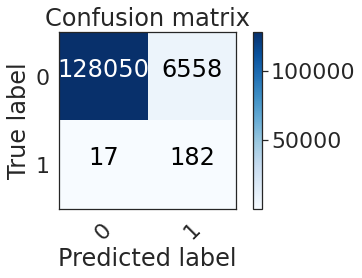

In [22]:
cm = confusion_matrix(y_test_all, prediction_SVM_all)
plot_confusion_matrix(cm,class_names)

In [23]:
print('Our criterion give a result of ' 
      + str( ( (cm[0][0]+cm[1][1]) / (sum(cm[0]) + sum(cm[1])) + 4 * cm[1][1]/(cm[1][0]+cm[1][1])) / 5))

Our criterion give a result of 0.9219036051279416


In [24]:
print('We have detected ' + str(cm[1][1]) + ' frauds / ' + str(cm[1][1]+cm[1][0]) + ' total frauds.')
print('\nSo, the probability to detect a fraud is ' + str(cm[1][1]/(cm[1][1]+cm[1][0])))
print("the accuracy is : "+str((cm[0][0]+cm[1][1]) / (sum(cm[0]) + sum(cm[1]))))

We have detected 182 frauds / 199 total frauds.

So, the probability to detect a fraud is 0.914572864321608
the accuracy is : 0.9512265683532755


### Models Rank

In [25]:
classifier.fit(X_train_rank, y_train) # Then we train our model, with our balanced data train.
prediction_SVM = classifier.predict(X_test_all_rank) #And finally, we predict our data test.

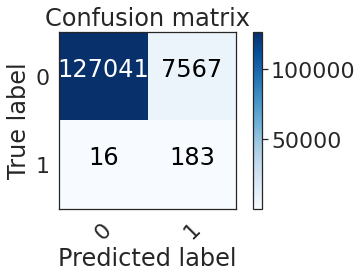

In [26]:
cm = confusion_matrix(y_test_all, prediction_SVM)
plot_confusion_matrix(cm,class_names)

In [27]:
print('Our criterion give a result of ' 
      + str( ( (cm[0][0]+cm[1][1]) / (sum(cm[0]) + sum(cm[1])) + 4 * cm[1][1]/(cm[1][0]+cm[1][1])) / 5))

Our criterion give a result of 0.9244282343270351


In [28]:
print('We have detected ' + str(cm[1][1]) + ' frauds / ' + str(cm[1][1]+cm[1][0]) + ' total frauds.')
print('\nSo, the probability to detect a fraud is ' + str(cm[1][1]/(cm[1][1]+cm[1][0])))
print("the accuracy is : "+str((cm[0][0]+cm[1][1]) / (sum(cm[0]) + sum(cm[1]))))

We have detected 183 frauds / 199 total frauds.

So, the probability to detect a fraud is 0.9195979899497487
the accuracy is : 0.9437492118361807


### Re-balanced class weight

In [29]:
classifier_b = svm.SVC(kernel='linear',class_weight={0:0.60, 1:0.40})

In [30]:
classifier_b.fit(X_train, y_train) # Then we train our model, with our balanced data train.

SVC(class_weight={0: 0.6, 1: 0.4}, kernel='linear')

### Testing the model

In [34]:
prediction_SVM_b_all = classifier_b.predict(X_test_all) #We predict all the data set.

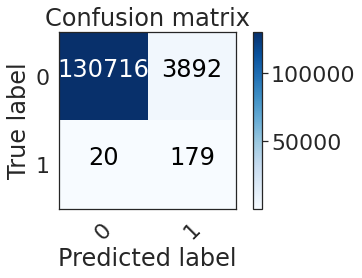

In [35]:
cm = confusion_matrix(y_test_all, prediction_SVM_b_all)
plot_confusion_matrix(cm,class_names)

In [36]:
print('Our criterion give a result of ' 
      + str( ( (cm[0][0]+cm[1][1]) / (sum(cm[0]) + sum(cm[1])) + 4 * cm[1][1]/(cm[1][0]+cm[1][1])) / 5))

Our criterion give a result of 0.913794137034099


In [37]:
print('We have detected ' + str(cm[1][1]) + ' frauds / ' + str(cm[1][1]+cm[1][0]) + ' total frauds.')
print('\nSo, the probability to detect a fraud is ' + str(cm[1][1]/(cm[1][1]+cm[1][0])))
print("the accuracy is : "+str((cm[0][0]+cm[1][1]) / (sum(cm[0]) + sum(cm[1]))))

We have detected 179 frauds / 199 total frauds.

So, the probability to detect a fraud is 0.8994974874371859
the accuracy is : 0.9709807354217511


### Models Rank

In [42]:
classifier_b.fit(X_train_rank, y_train) # Then we train our model, with our balanced data train.
prediction_SVM = classifier_b.predict(X_test_all_rank) #And finally, we predict our data test.

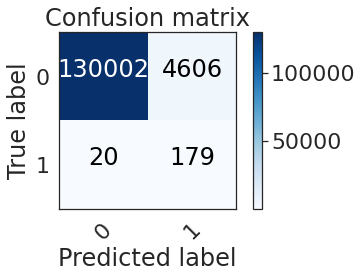

In [43]:
cm = confusion_matrix(y_test_all, prediction_SVM)
plot_confusion_matrix(cm,class_names)

In [44]:
print('Our criterion give a result of ' 
      + str( ( (cm[0][0]+cm[1][1]) / (sum(cm[0]) + sum(cm[1])) + 4 * cm[1][1]/(cm[1][0]+cm[1][1])) / 5))

Our criterion give a result of 0.9127348448608439


In [45]:
print('We have detected ' + str(cm[1][1]) + ' frauds / ' + str(cm[1][1]+cm[1][0]) + ' total frauds.')
print('\nSo, the probability to detect a fraud is ' + str(cm[1][1]/(cm[1][1]+cm[1][0])))
print("the accuracy is : "+str((cm[0][0]+cm[1][1]) / (sum(cm[0]) + sum(cm[1]))))

We have detected 179 frauds / 199 total frauds.

So, the probability to detect a fraud is 0.8994974874371859
the accuracy is : 0.9656842745554756
